# 🐝🎵 Introduction to Xylo™Audio

> **_Note:_** In this tutorial Xylo™Audio refers to Xylo™Audio 2 and Xylo™Audio 3. In case differences occur we will explicitly name the correct HDK.

In [1]:
# Specify the xylo board you would like to use for this tutorial

# Available boards: XyloAudio2 and XyloAudio3
xylo_board_name = 'XyloAudio3'


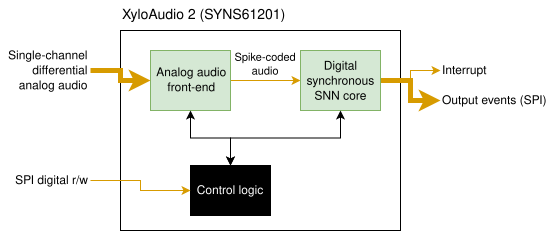

In [2]:
# - Display images
from IPython.display import Image

Image('xylo-a2-block-level.png')

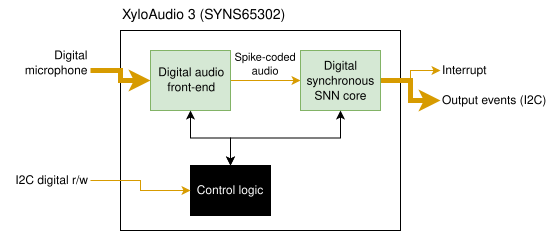

In [3]:
# - Display images
from IPython.display import Image

Image('xylo-a3-block-level.png')

## Part I: Using the XyloAudio SNN Core

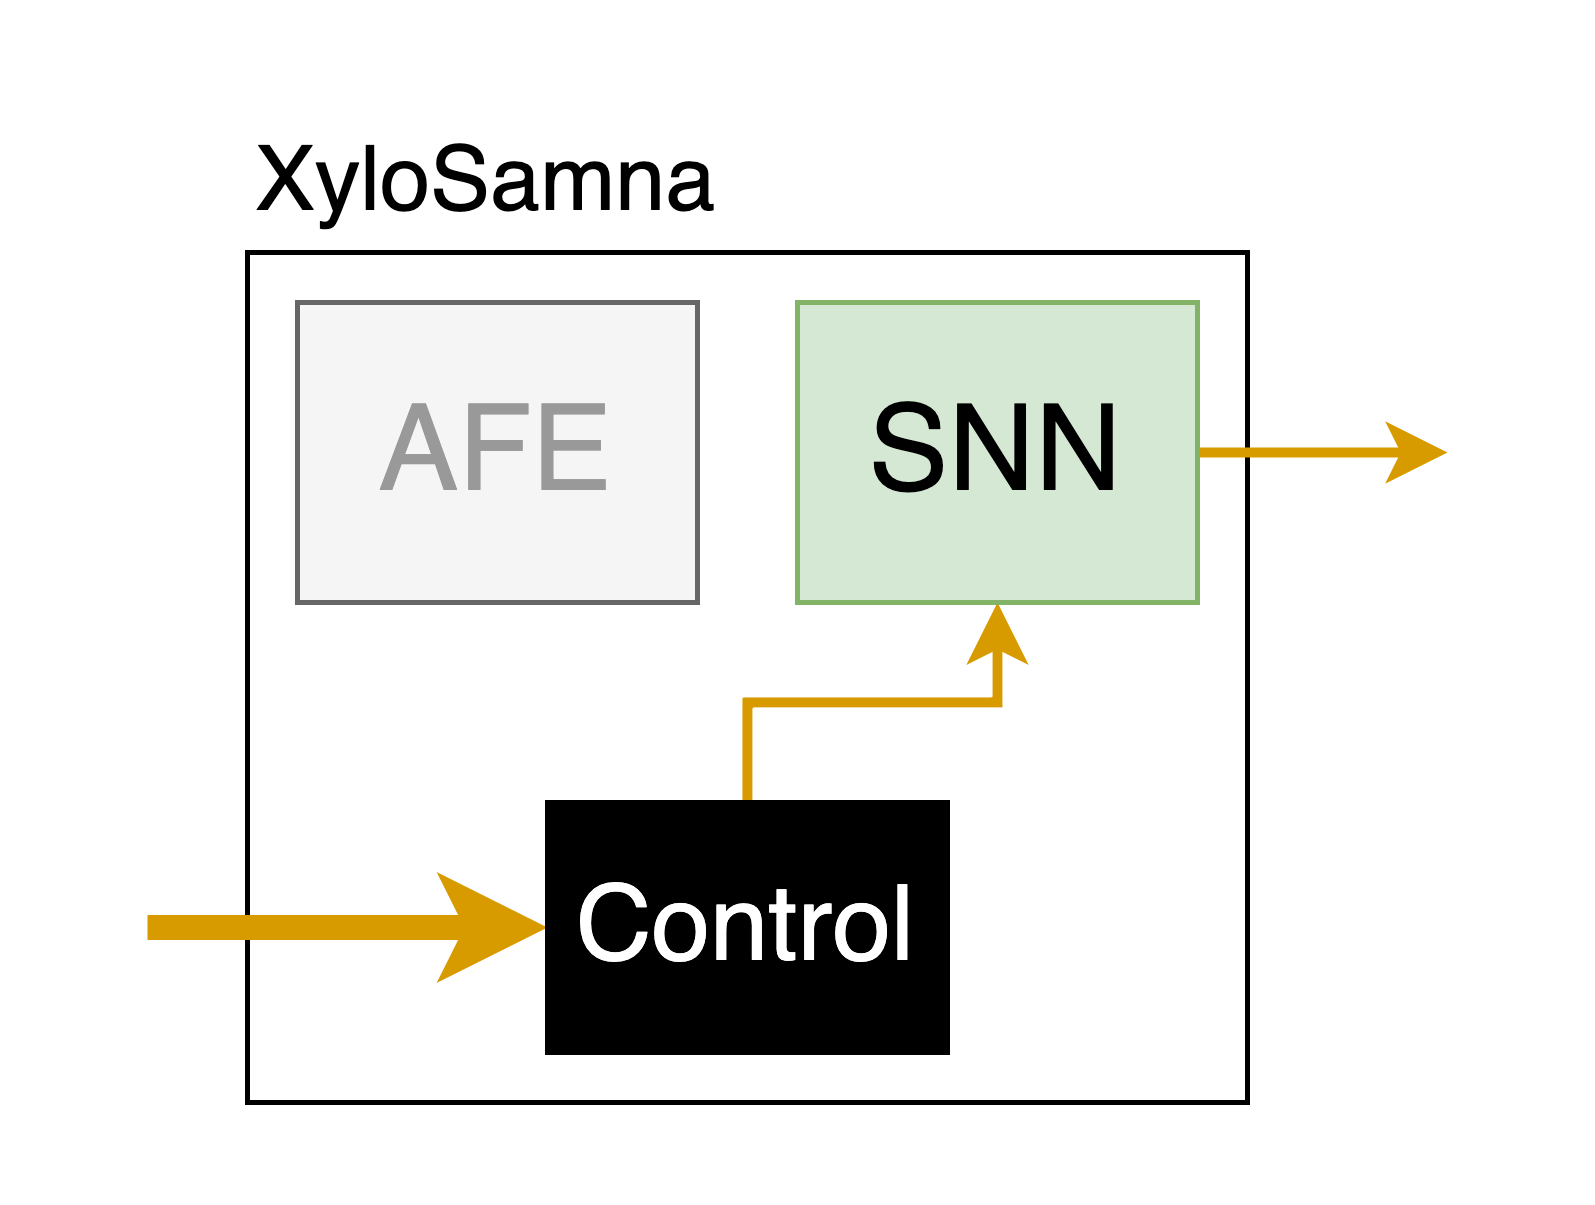

In [4]:
Image('XyloSamna.png', width=400)

### Step 1: Build a network in rockpool and convert it to a hardware configuration

In [5]:
# - Import the computational modules and combinators required for the network
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual
from rockpool.transform import quantize_methods as q
from rockpool import TSEvent, TSContinuous

# - Imports dependent on your HDK
# - XyloAudio 2
if xylo_board_name == 'XyloAudio2':
    import rockpool.devices.xylo.syns61201 as xa2
    from rockpool.devices.xylo.syns61201 import xa2_devkit_utils as xa2utils
# - XyloAudio 3
elif xylo_board_name == 'XyloAudio3':
    import rockpool.devices.xylo.syns65302 as xa3
    from rockpool.devices.xylo.syns65302 import xa3_devkit_utils as xa3utils

import numpy as np

try:
    from rich import print
except:
    pass

import sys
!{sys.executable} -m pip install --quiet matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

# - Disable warnings
import warnings
warnings.filterwarnings('ignore')

from IPython import display

WARNING    /home/vleite/.pyenv/versions/3.11.11/envs/rockpool311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 [py.warnings]
  from .autonotebook import tqdm as notebook_tqdm




[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [6]:
# - Define the size of the network layers
Nin = 2
Nhidden = 4
Nout = 2
dt = 1e-3

In [7]:
# - Define the network architecture using combinators and modules
net = Sequential(
    LinearTorch((Nin, Nhidden), has_bias = False),
    LIFTorch(Nhidden, dt = dt),
    
    Residual(
        LinearTorch((Nhidden, Nhidden), has_bias = False),
        LIFTorch(Nhidden, has_rec = True, threshold = 1., dt = dt),
    ),
    
    LinearTorch((Nhidden, Nout), has_bias = False),
    LIFTorch(Nout, dt = dt),
)
print(net)

# - Scale down recurrent weights for stability
# net[2][1].w_rec.data = net[2][1].w_rec / 10.

TorchSequential  with shape (2, 2) {
    LinearTorch '0_LinearTorch' with shape (2, 4)
    LIFTorch '1_LIFTorch' with shape (4, 4)
    TorchResidual '2_TorchResidual' with shape (4, 4) {
        LinearTorch '0_LinearTorch' with shape (4, 4)
        LIFTorch '1_LIFTorch' with shape (4, 4)
    }
    LinearTorch '3_LinearTorch' with shape (4, 2)
    LIFTorch '4_LIFTorch' with shape (2, 2)
}

In [8]:
# - Call the Xylo mapper on the extracted computational graph
# - For XyloAudio 2
if xylo_board_name == 'XyloAudio2':
    spec = xa2.mapper(net.as_graph(),  weight_dtype='float', threshold_dtype='float', dash_dtype='float')
# - For XyloAudio 3
elif xylo_board_name == 'XyloAudio3':
    spec = xa3.mapper(net.as_graph(),  weight_dtype='float', threshold_dtype='float', dash_dtype='float')

# - Quantize the specification
spec.update(q.global_quantize(**spec))

# # you can also try channel-wise quantization
# spec.update(q.channel_quantize(**spec))
# print(spec)

# - Use rockpool.devices.xylo.config_from_specification to convert it to a hardware configuration
# - For XyloAudio 2
if xylo_board_name == 'XyloAudio2':
    config, is_valid, msg = xa2.config_from_specification(**spec)
# - For XyloAudio 3
elif xylo_board_name == 'XyloAudio3':
    config, is_valid, msg = xa3.config_from_specification(**spec)

if not is_valid:
    print(msg)

In [9]:
# - Use rockpool.devices.xylo.find_xylo_hdks to connect to an HDK
from rockpool.devices.xylo import find_xylo_hdks
xylo_hdk_nodes, modules, versions = find_xylo_hdks()
print(versions)

hdk = None

for version, xylo in zip(versions, xylo_hdk_nodes):
    if version == "syns61201":
        hdk = xylo
    # - For XyloAudio 3
    elif version == "syns65302":
        hdk = xylo

if hdk is None:
    assert False, 'This tutorial requires a connected XyloAudio HDK to demonstrate.'
    

The connected Xylo HDK contains a XyloAudio 3. Importing `rockpool.devices.xylo.syns65302`


['syns65302']

In [10]:
# - Use XyloSamna to deploy to the HDK
if hdk:
    # - For XyloAudio 2
    if xylo_board_name == 'XyloAudio2':
        modSamna = xa2.XyloSamna(hdk, config, dt = dt) 
    # - For XyloAudio 3
    elif xylo_board_name == 'XyloAudio3':
        modSamna = xa3.XyloSamna(hdk, config, dt = dt) 

print(modSamna)

XyloSamna  with shape (2, 8, 2)

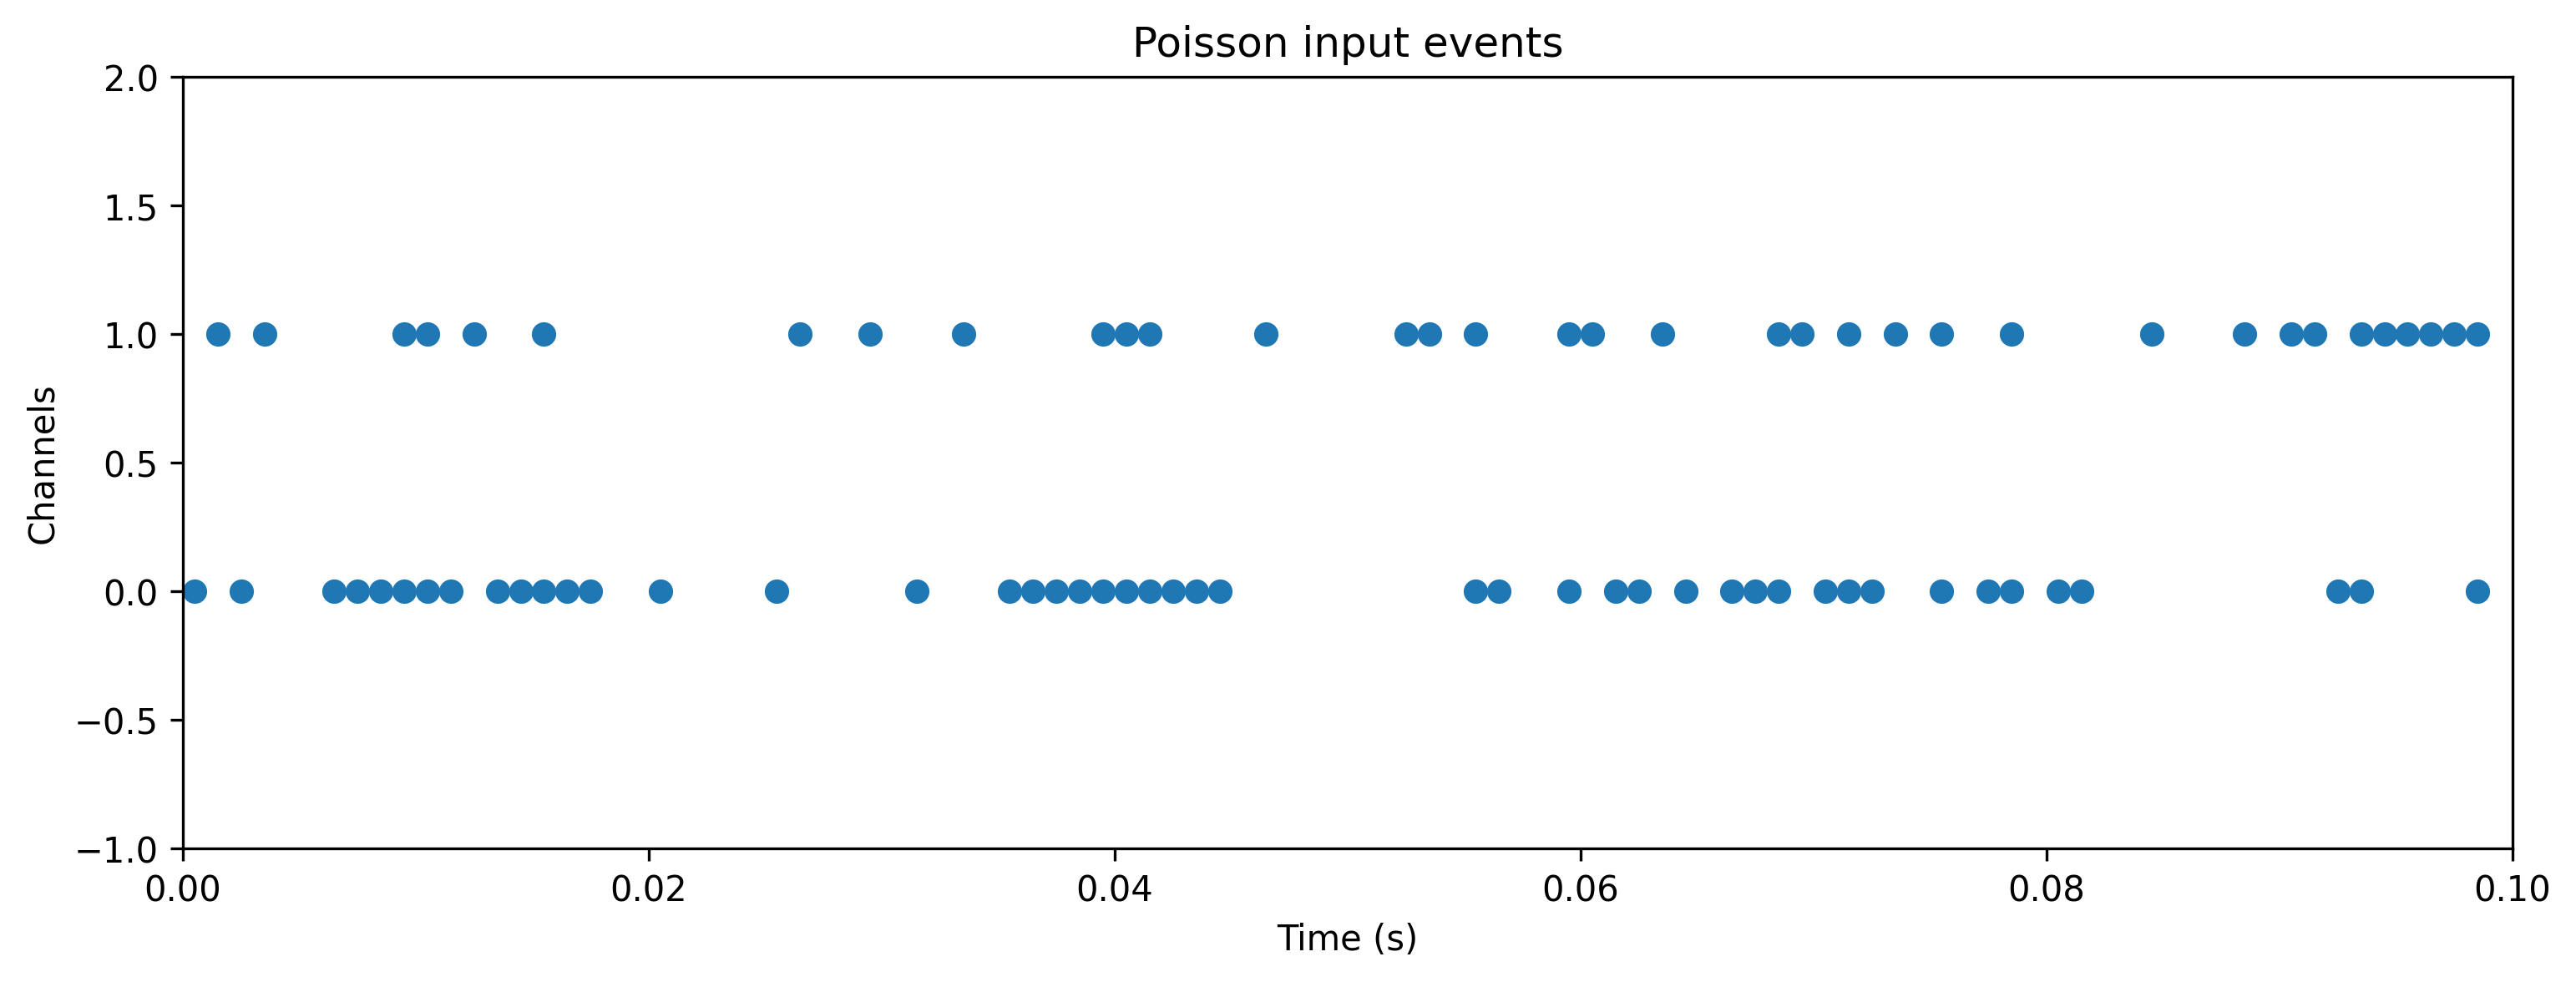

In [11]:
# - Generate some Poisson input
T = 100
f = 0.4
input_spikes = np.random.rand(T, Nin) < f
TSEvent.from_raster(input_spikes, dt, name = 'Poisson input events').plot();

In [12]:
# - Evolve the network on the Xylo HDK
# - `reset_state` is only needed for XyloAudio 2
if xylo_board_name == 'XyloAudio2':
    modSamna.reset_state()
    
out, _, r_d = modSamna(input_spikes, record = True)

# - Show the internal state variables recorded 
print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Isyn2', 'Spikes', 'Vmem_out', 'Isyn_out', 'times', 'inf_duration'])

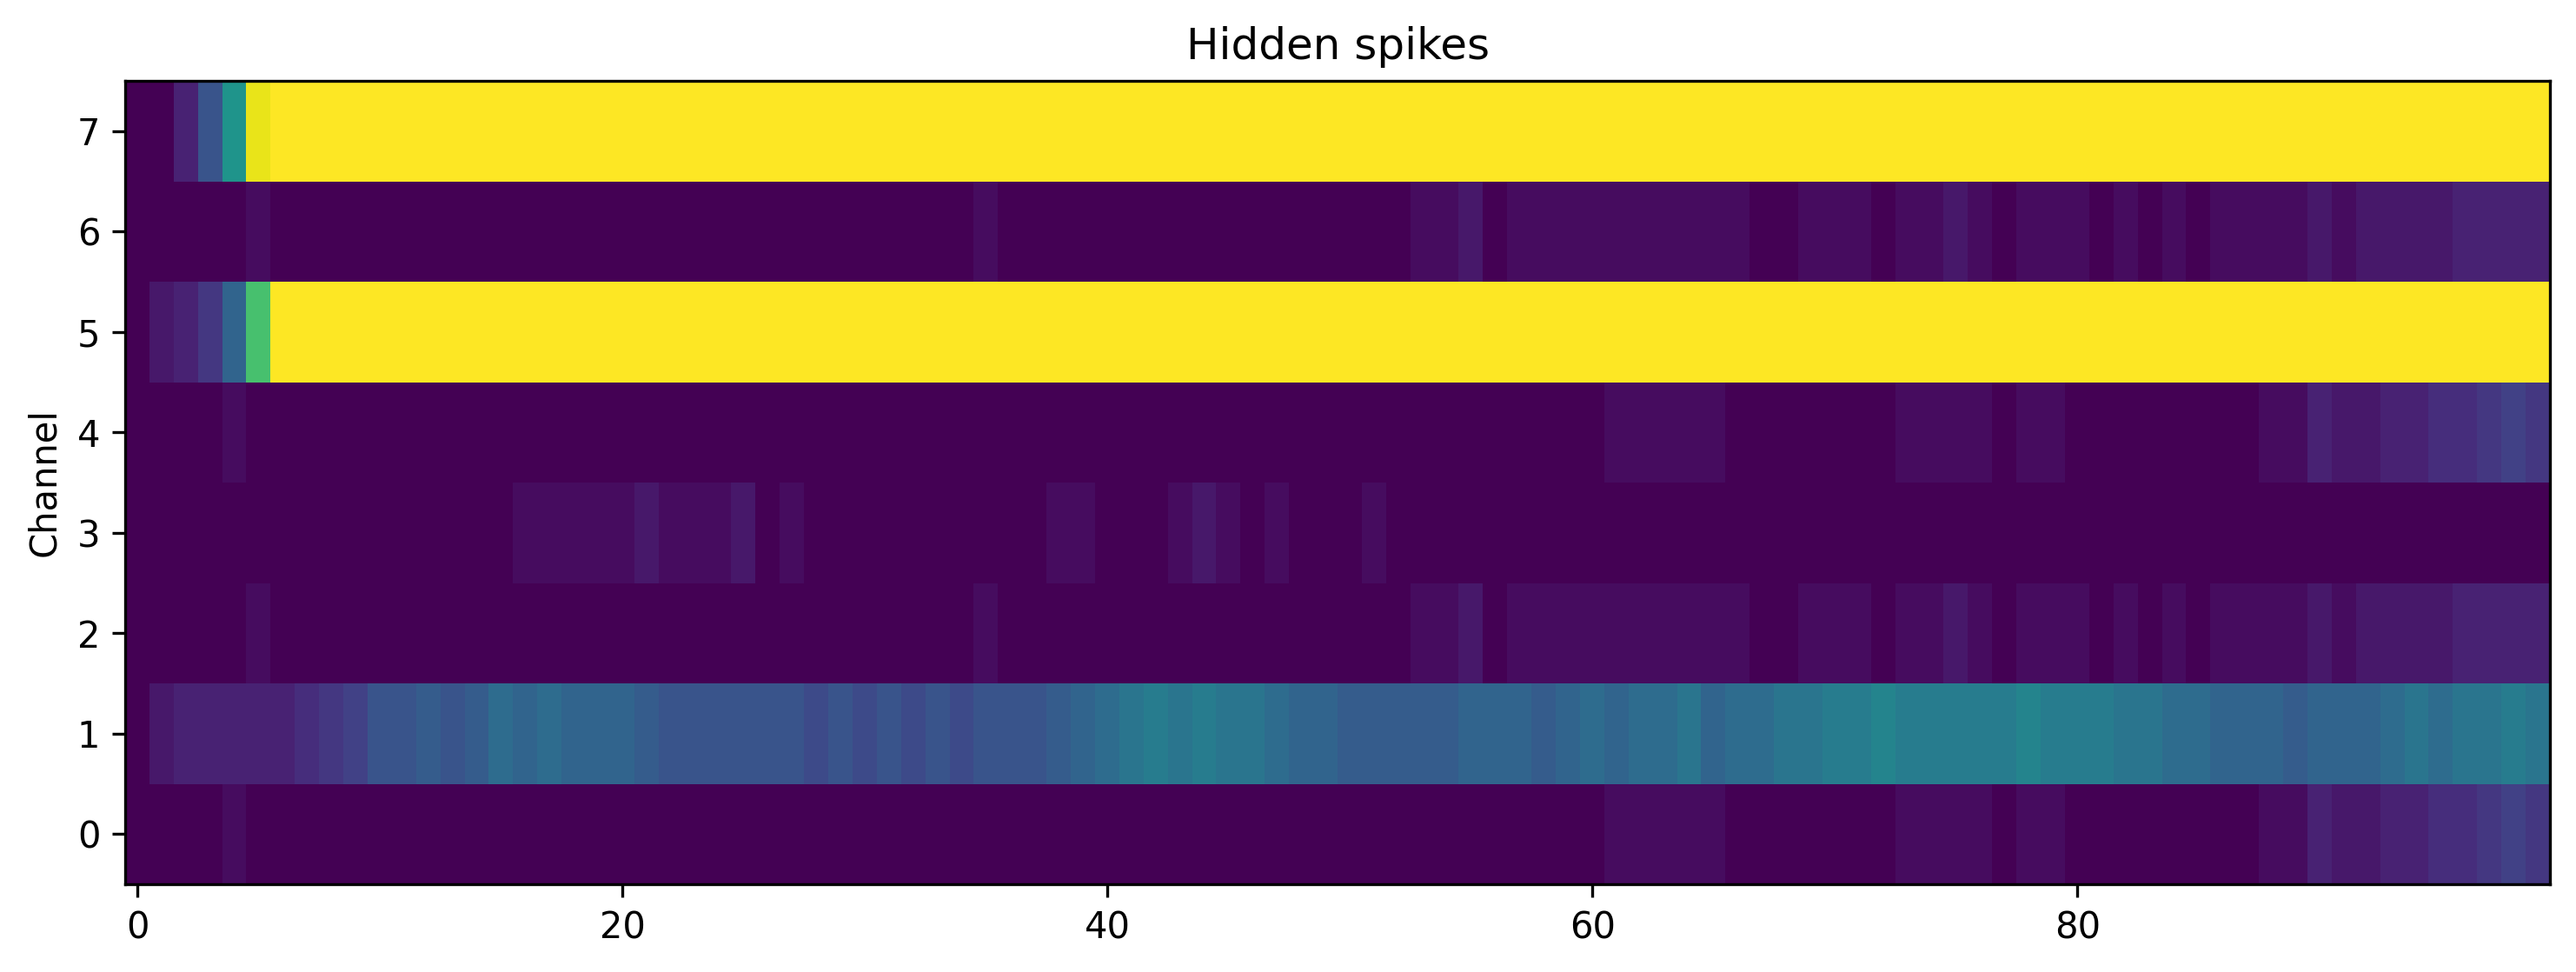

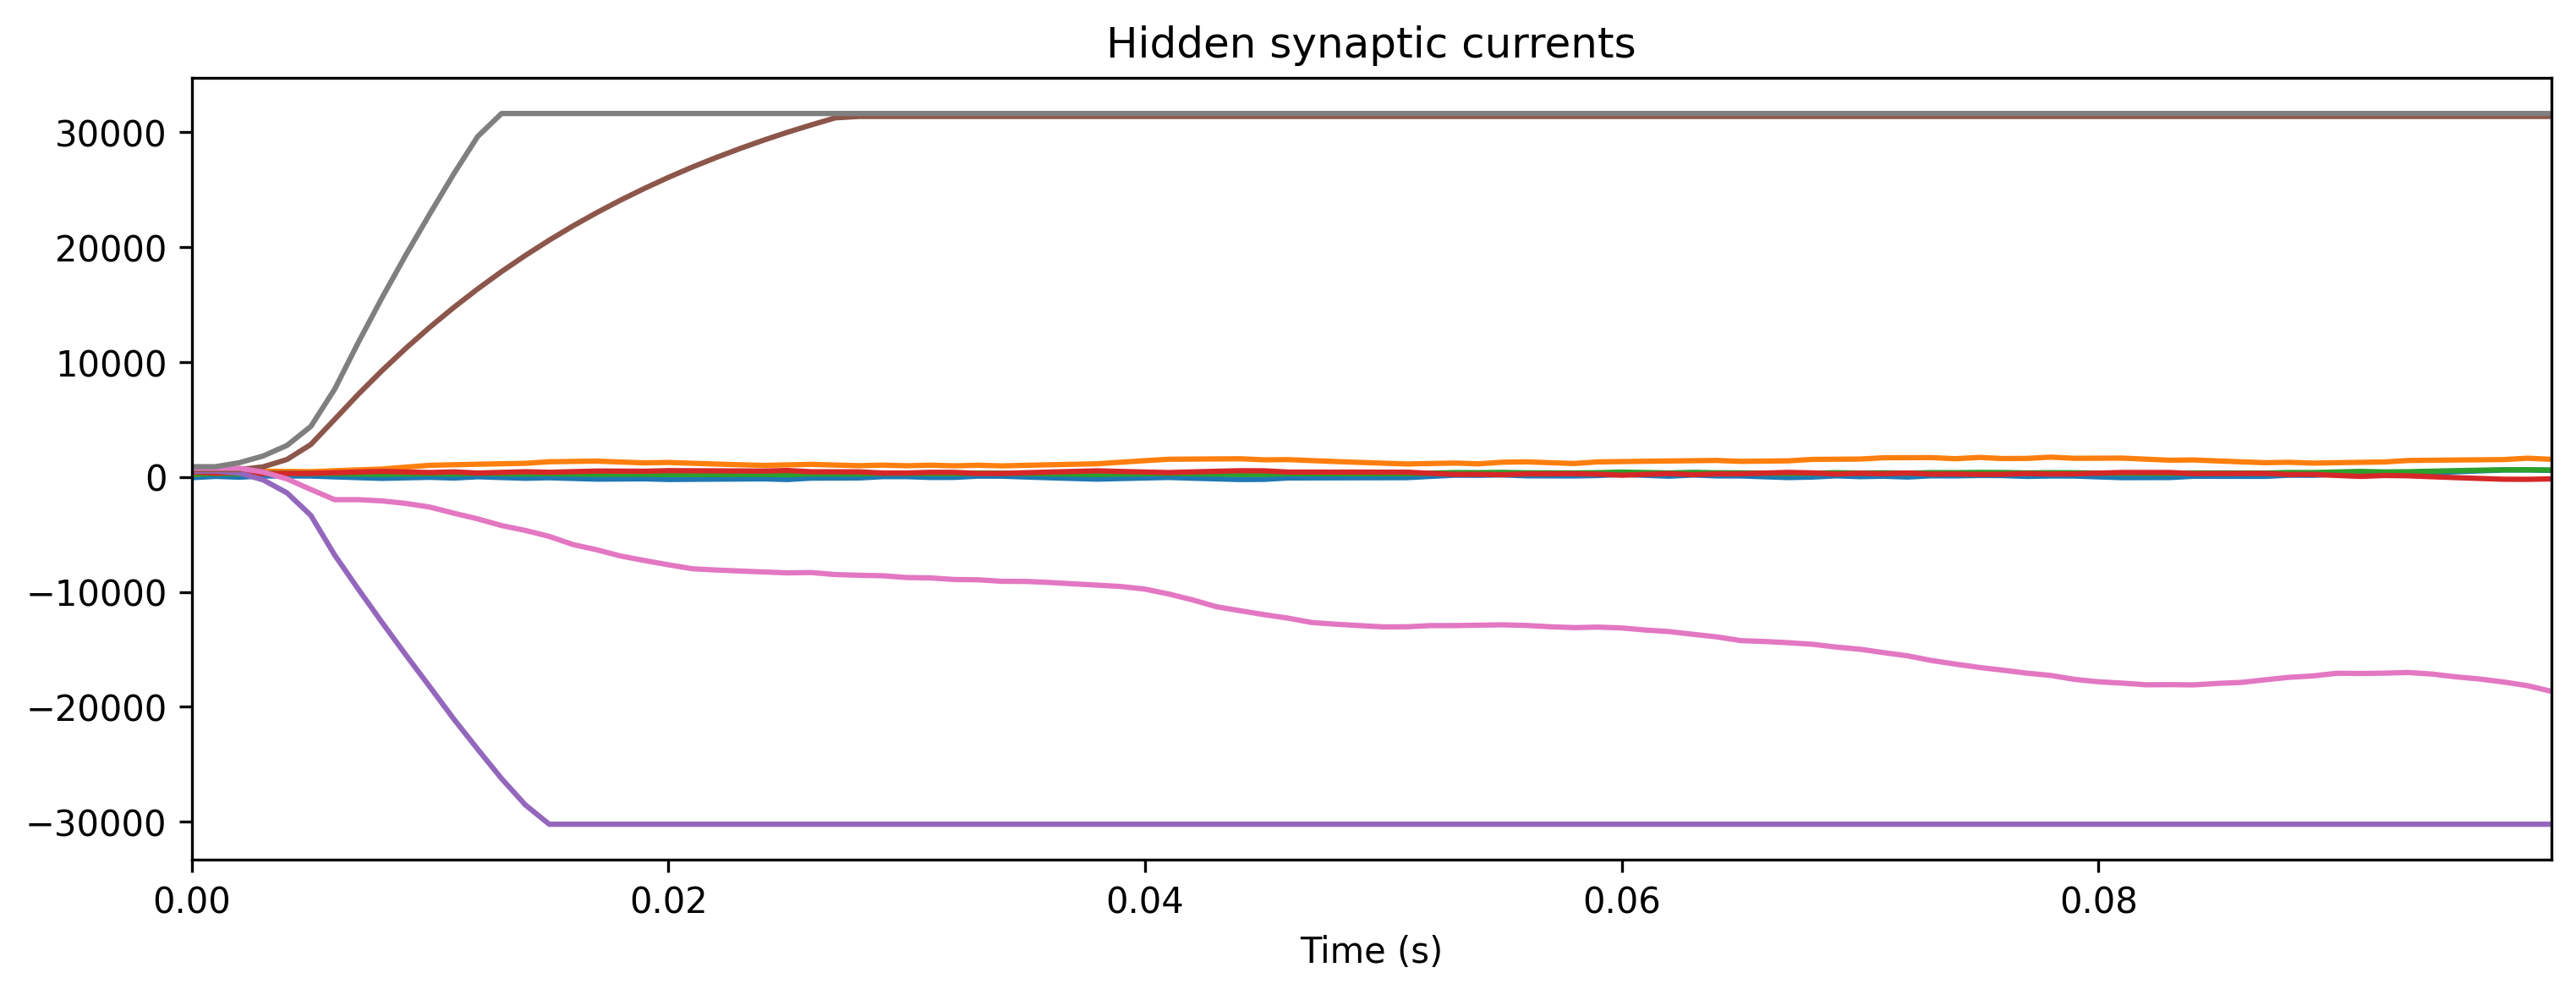

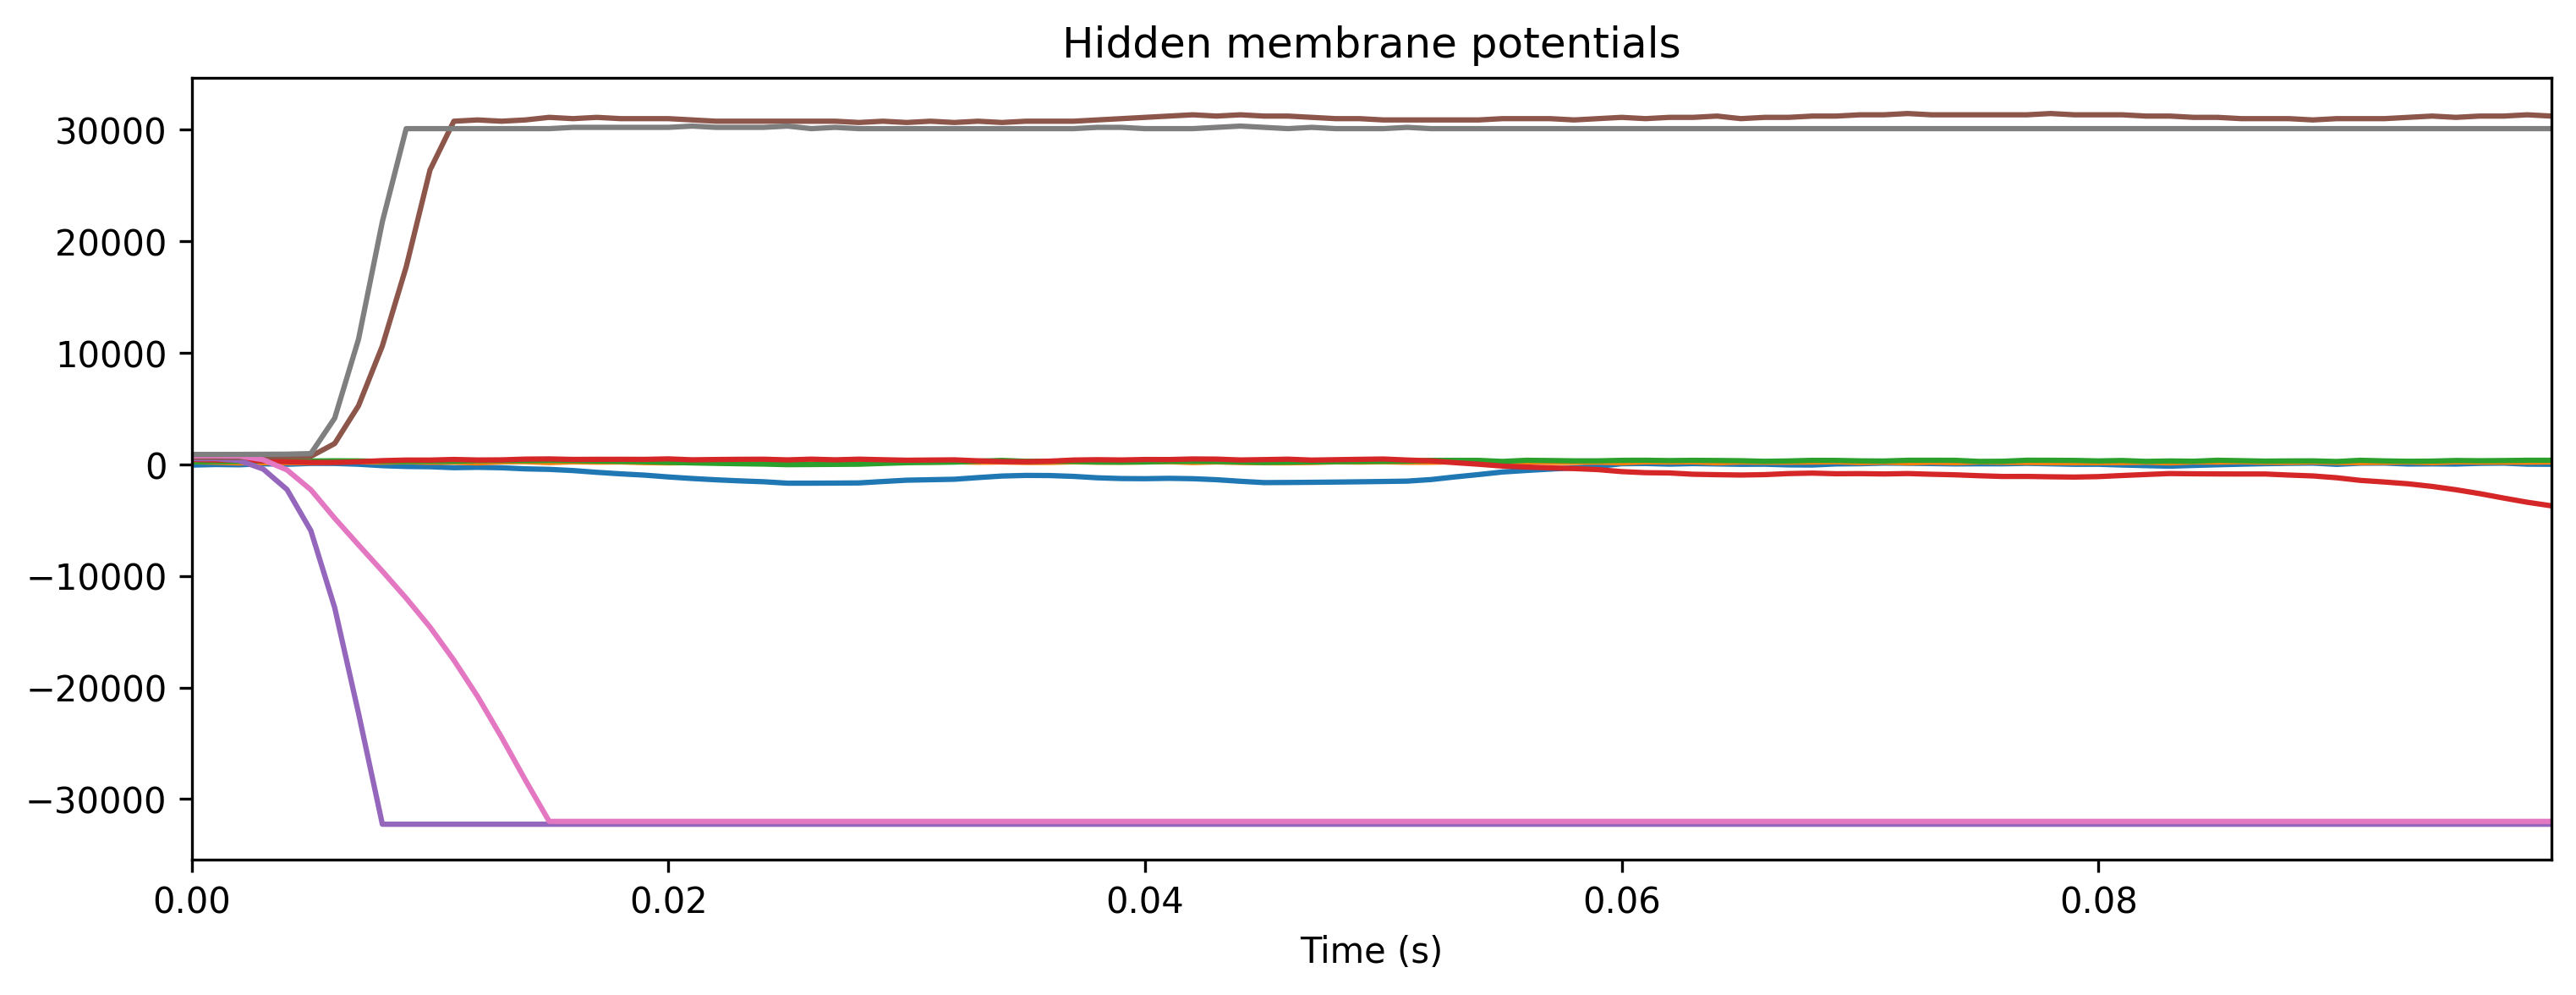

In [13]:
# - Plot some internal state variables
plt.figure()
plt.imshow(r_d['Spikes'].T, aspect = 'auto', origin = 'lower')
plt.title('Hidden spikes')
plt.ylabel('Channel')

plt.figure()
TSContinuous(r_d['times'], r_d['Isyn'], name = 'Hidden synaptic currents').plot(stagger = 127)

plt.figure()
TSContinuous(r_d['times'], r_d['Vmem'], name = 'Hidden membrane potentials').plot(stagger = 127);

### Step 3: Simulate the HDK using the `XyloSim` bit-precise simulator

In [14]:
# - Configure the simulator with the HW network config
# - For XyloAudio 2
if xylo_board_name == 'XyloAudio2':
    modSim = xa2.XyloSim.from_config(config, dt=dt)
# - For XyloAudio 3
elif xylo_board_name == 'XyloAudio3':
    modSim = xa3.XyloSim.from_config(config, dt=dt)

print(modSim)

XyloSim  with shape (2, 8, 2)

In [15]:
# - Evolve the input over the network, in simulation
out, _, r_d = modSim(input_spikes, record = True)

# - Show the internal state variables recorded 
del modSim
print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Spikes', 'Vmem_out', 'Isyn_out'])

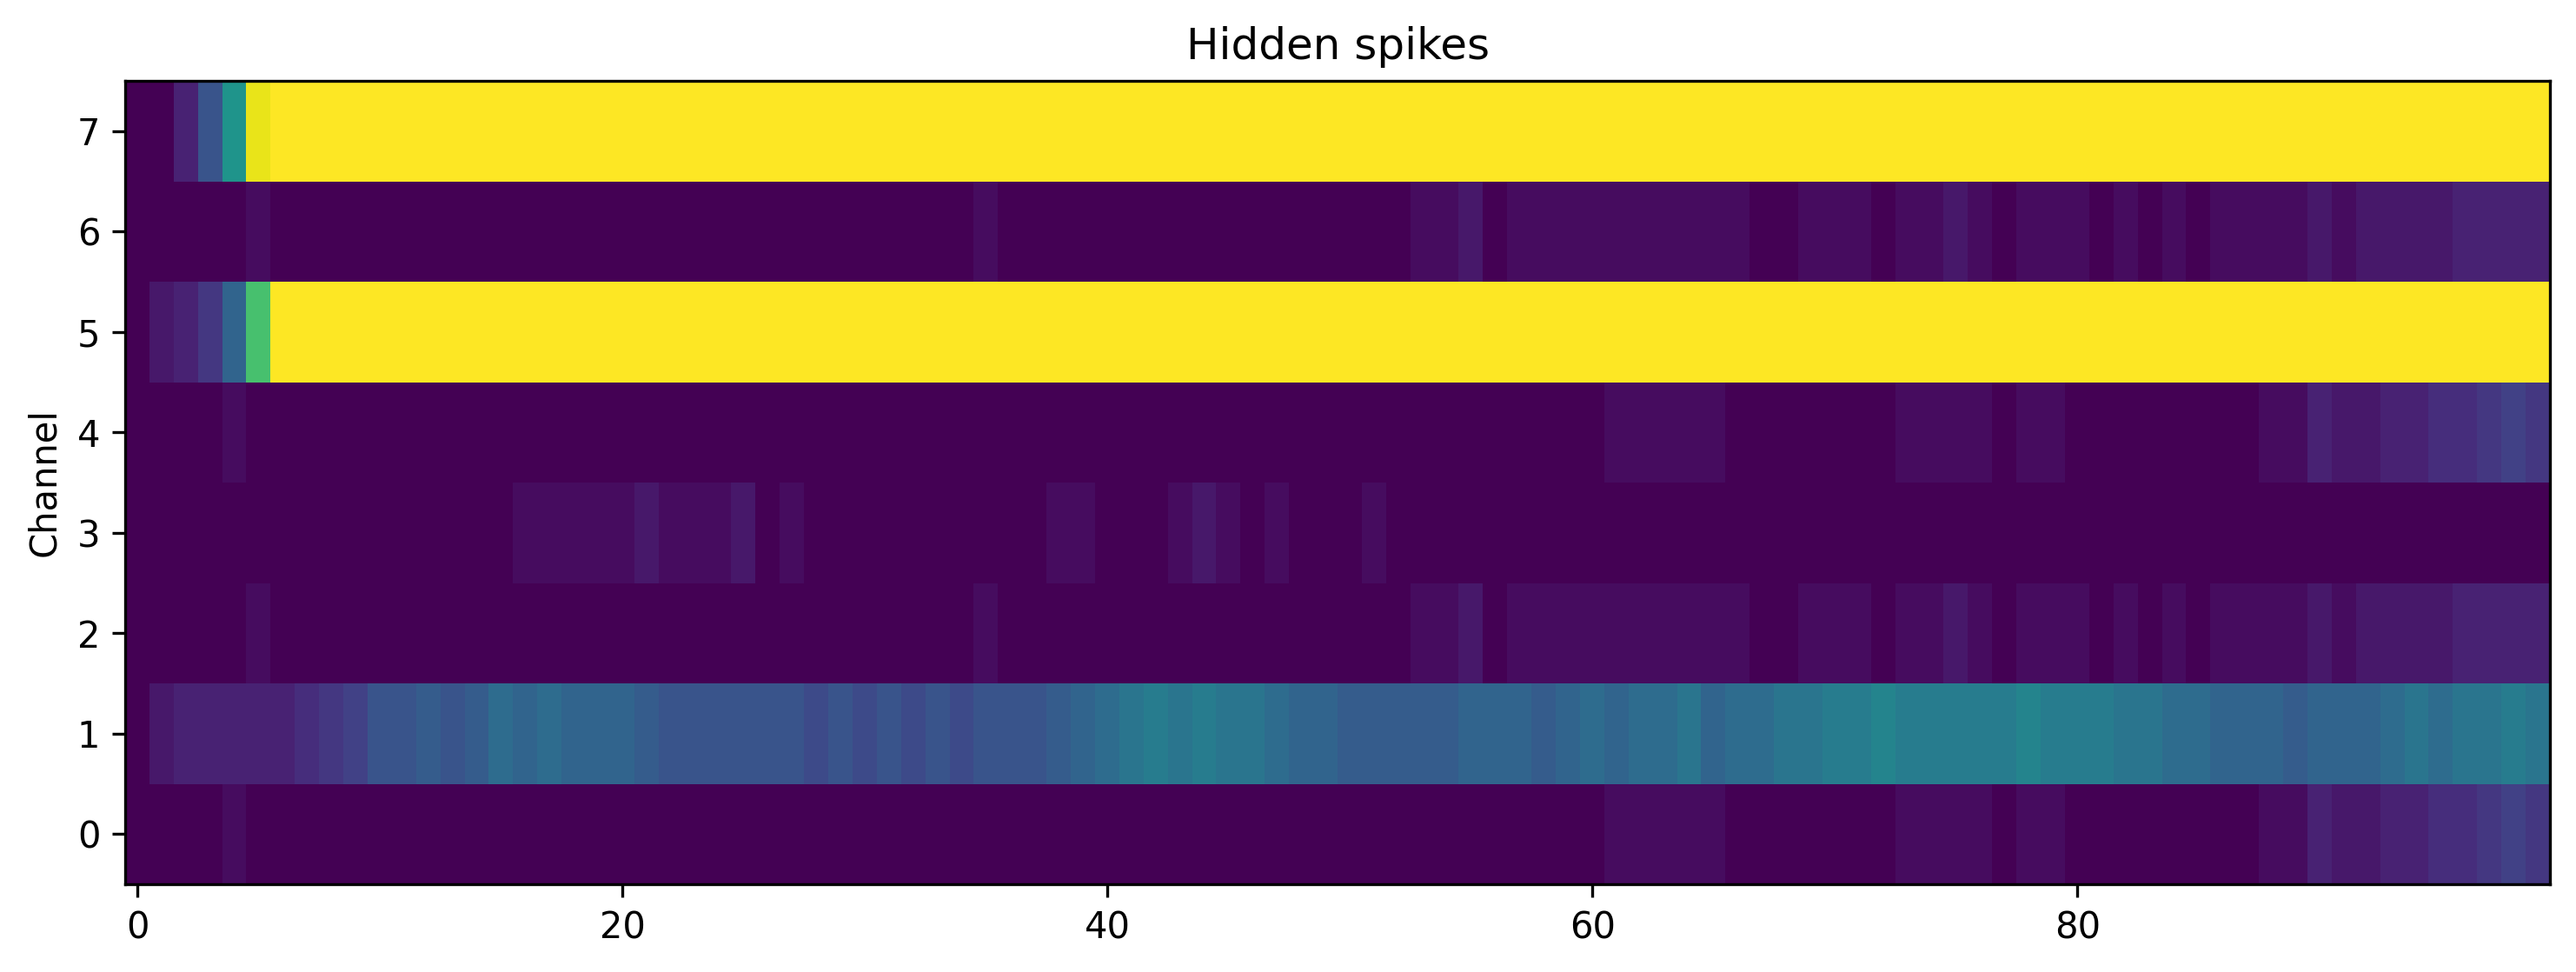

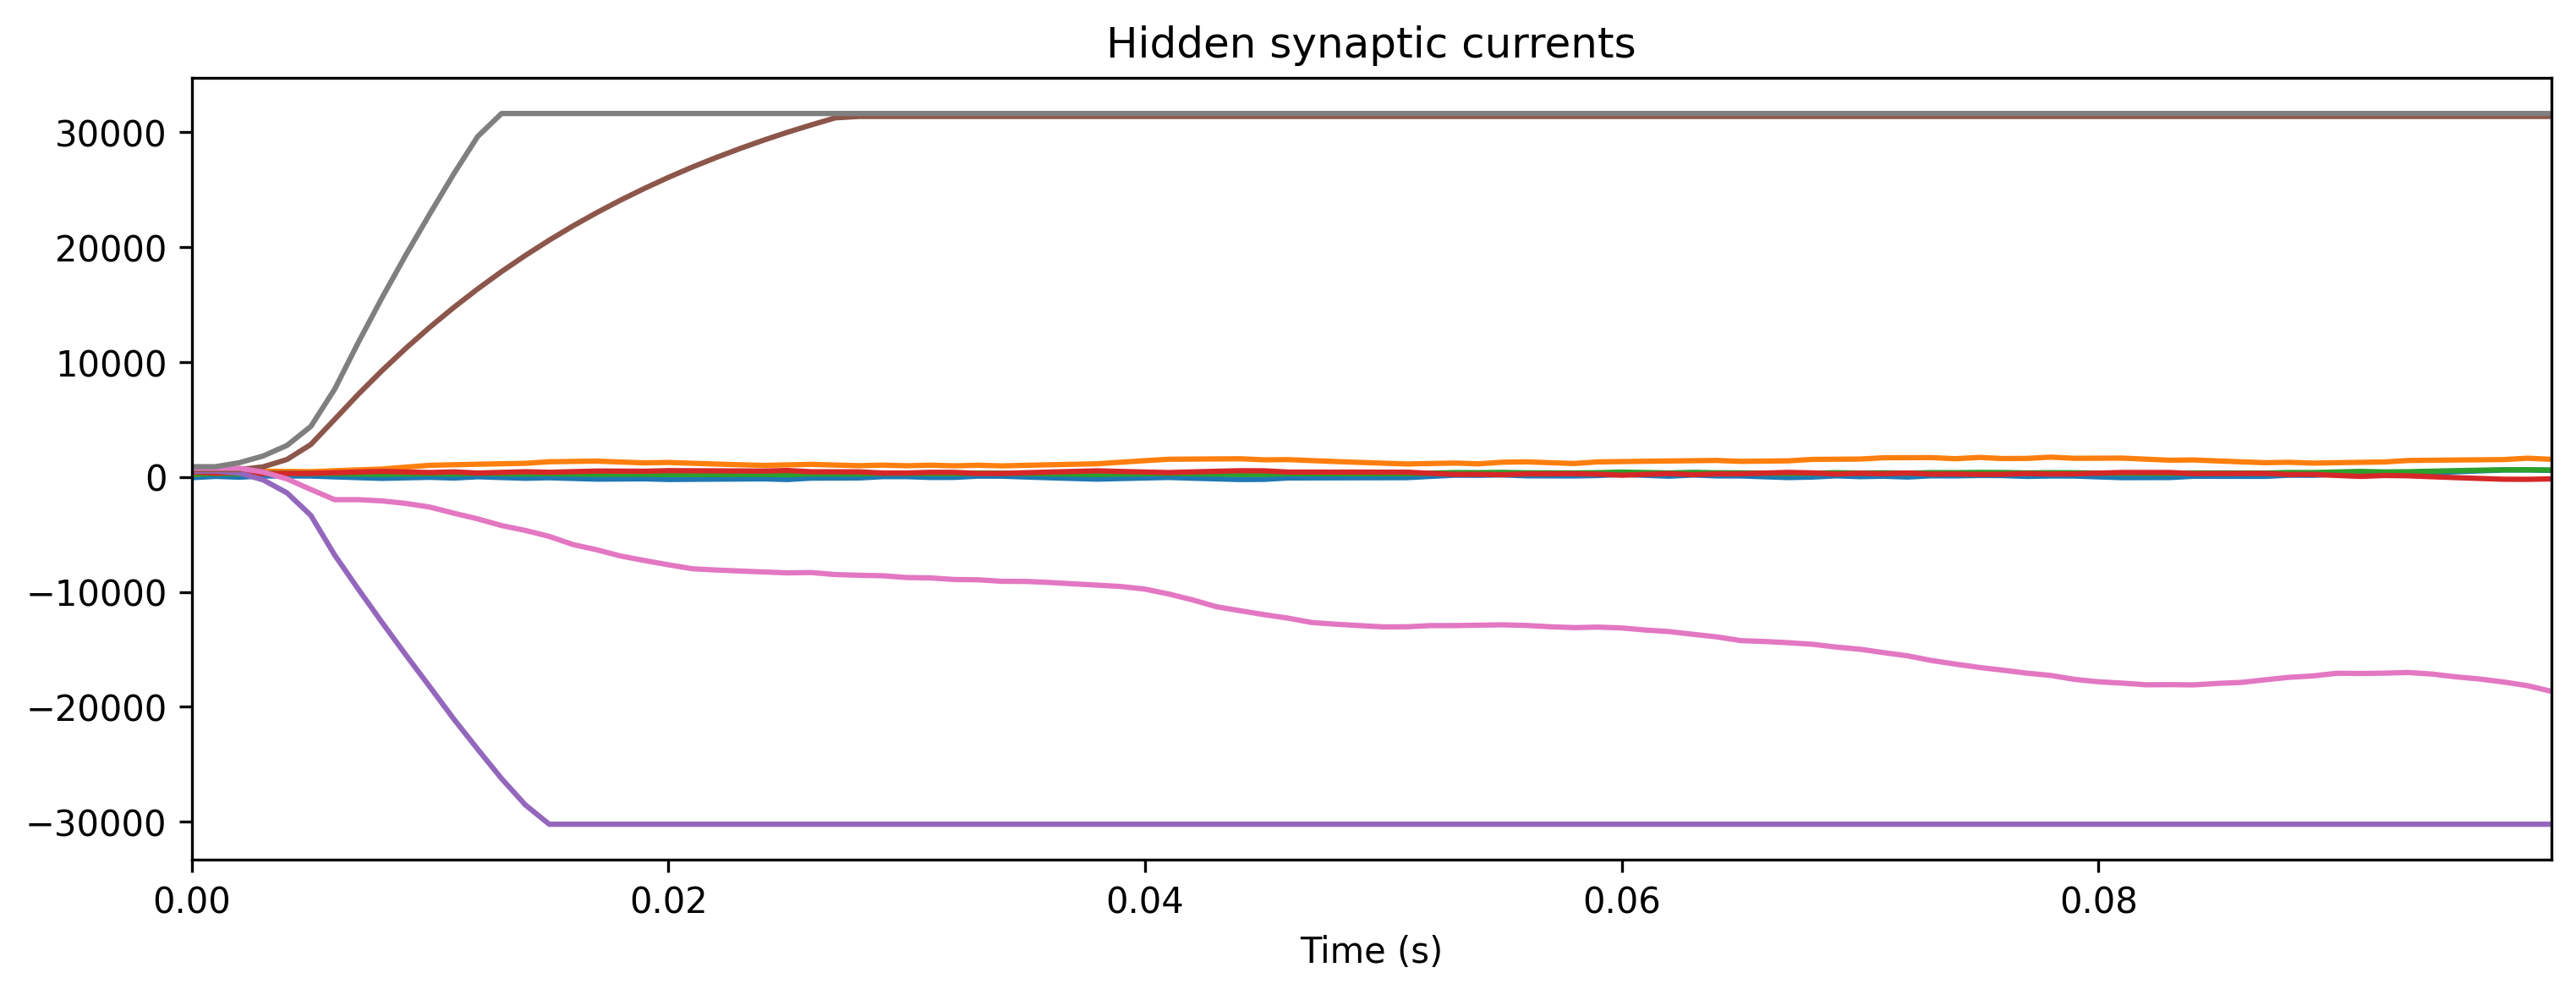

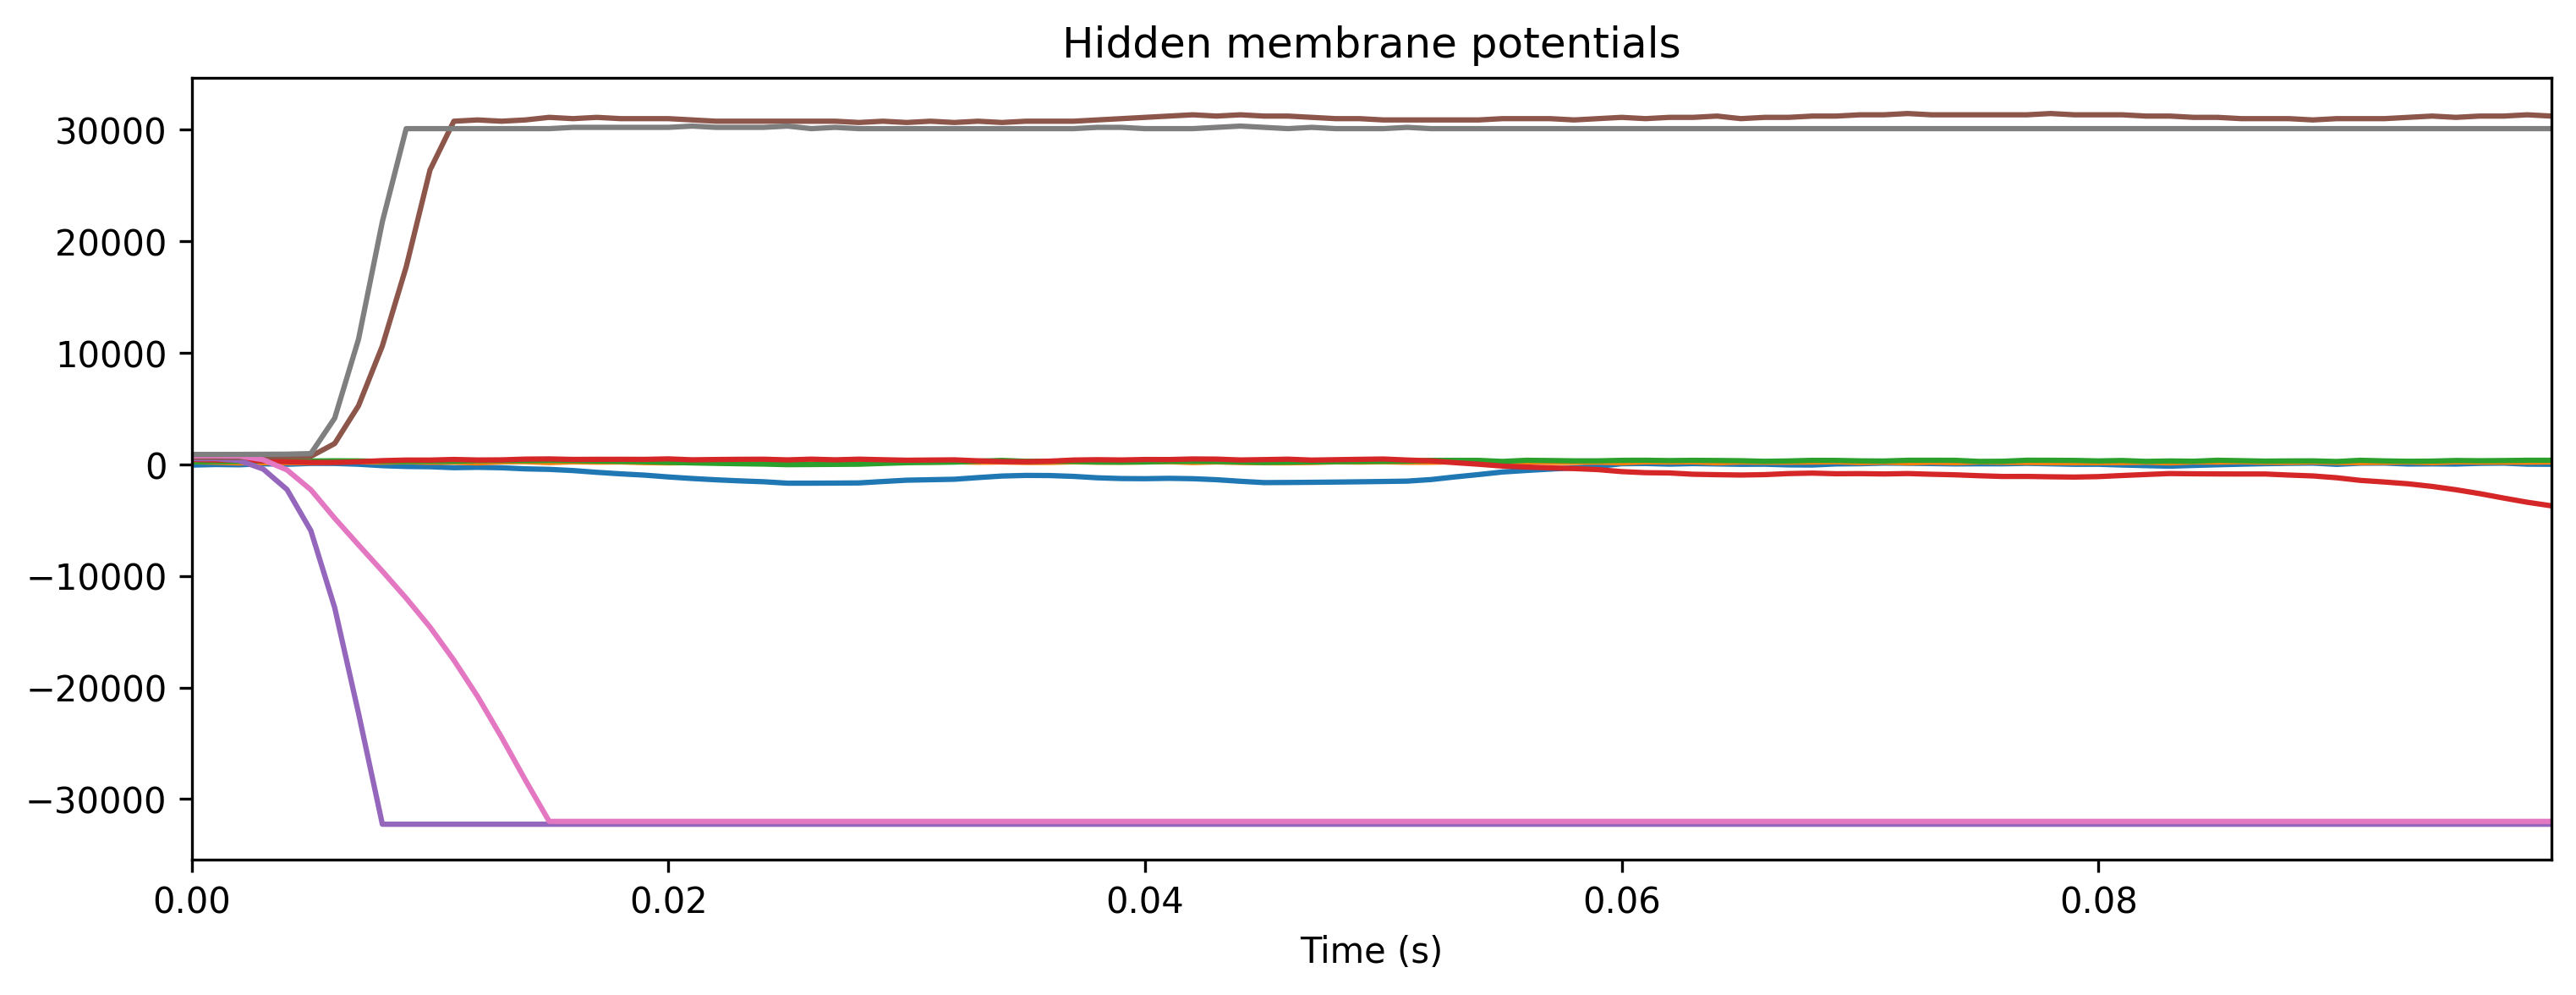

In [16]:
# - Plot some internal state variables
plt.figure()
plt.imshow(r_d['Spikes'].T, aspect = 'auto', origin = 'lower')
plt.title('Hidden spikes')
plt.ylabel('Channel')

plt.figure()
TSContinuous.from_clocked(r_d['Isyn'], dt, name = 'Hidden synaptic currents').plot(stagger = 127);

plt.figure()
TSContinuous.from_clocked(r_d['Vmem'], dt, name = 'Hidden membrane potentials').plot(stagger = 127);

## Part II: Using the XyloAudio audio front-end interface

> **_Note:_** Audio front-end is only available in Xylo™Audio 2. This step does not applied to Xylo™Audio 3.

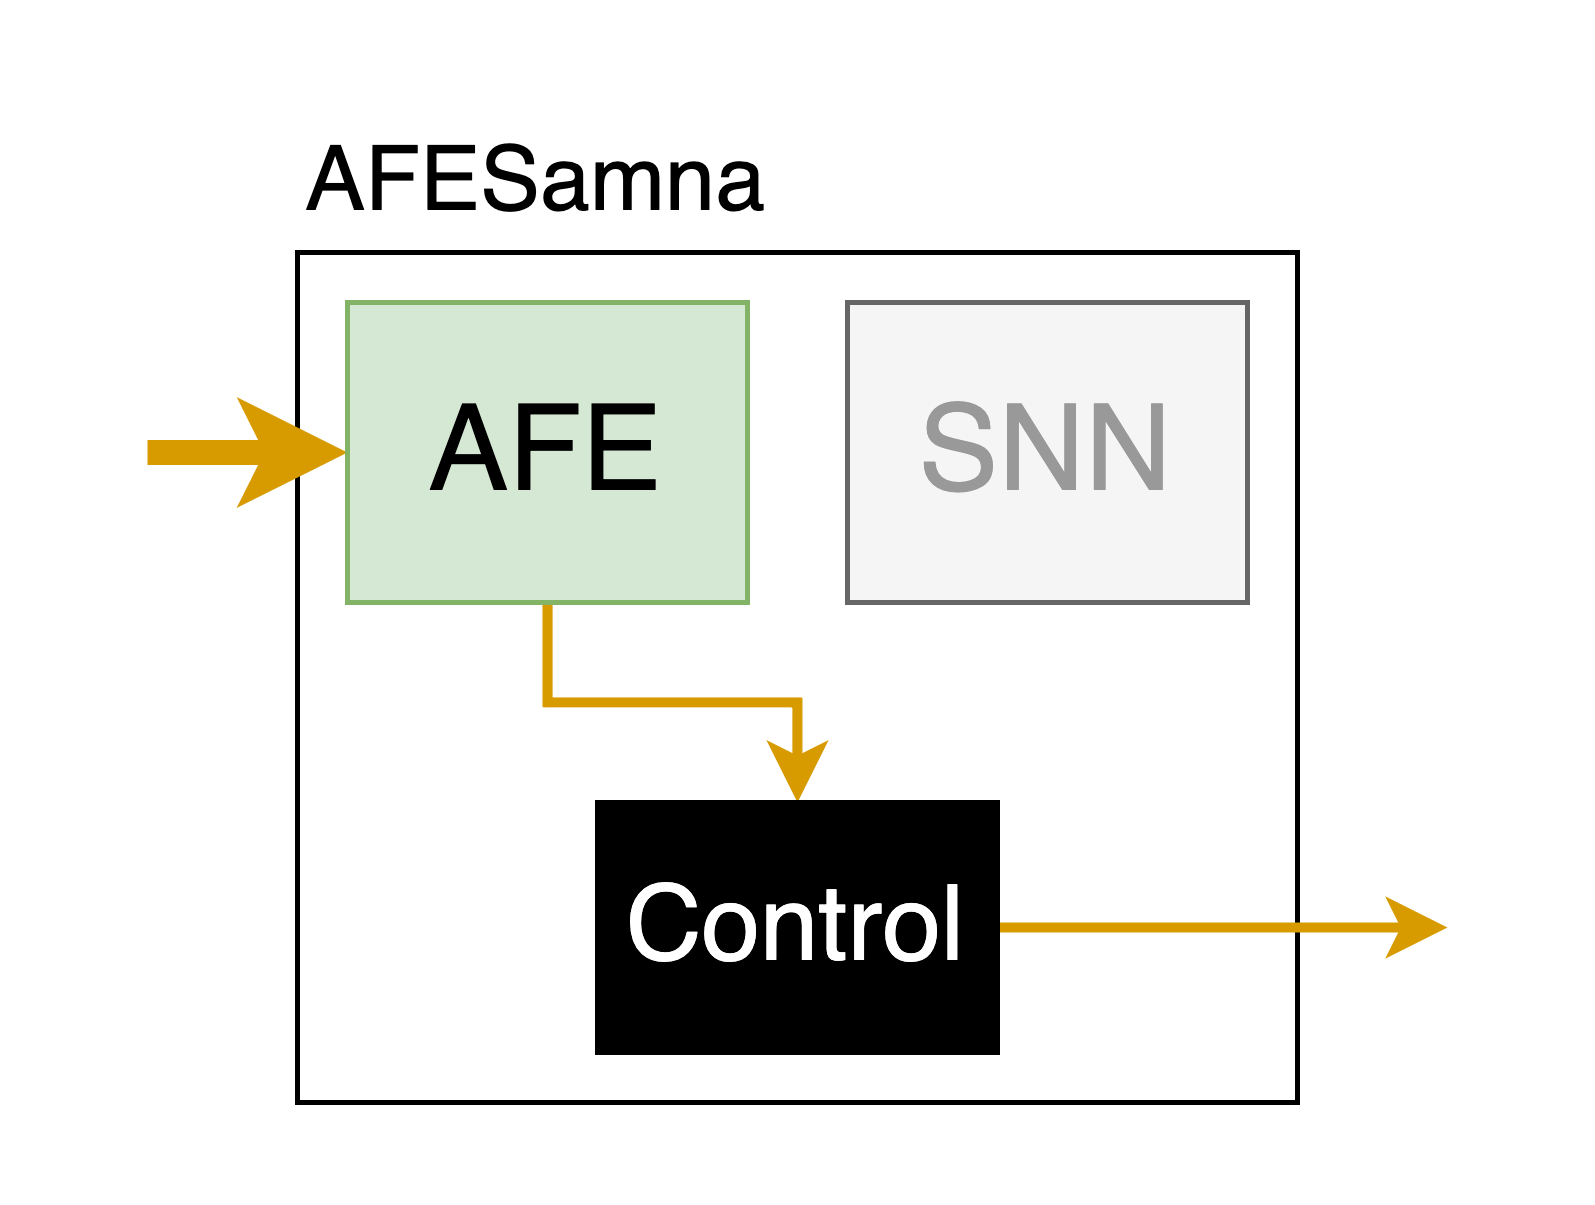

In [17]:
Image('AFESamna.png', width=400)

In [18]:
# - Find and connect to a XyloAudio HDK
from rockpool.devices.xylo import find_xylo_hdks
xylo_hdk_nodes, modules, versions = find_xylo_hdks()
print(versions)

hdk = None

for version, xylo in zip(versions, xylo_hdk_nodes):
    if version == "syns61201":
        hdk = xylo
    if version == "syns65302":
        hdk = xylo

if hdk is None:
    assert False, 'This tutorial requires a connected XyloAudio HDK to demonstrate.'



The connected Xylo HDK contains a XyloAudio 3. Importing `rockpool.devices.xylo.syns65302`


['syns65302']

In [19]:
# - Set the time resolution and duration to record encoded audio
dt = 10e-3
timesteps = 1000

In [20]:
# - Create an AFESamna module, which wraps the AFE on the Xylo A2 HDK
#   (stay quiet while this cell is executing)
if xylo_board_name == 'XyloAudio2':
    mod = xa2.AFESamna(hdk, None, dt=dt, auto_calibrate=True, amplify_level='low', hibernation_mode=False)
elif xylo_board_name == 'XyloAudio3':
    mod = xa3.AFESamna(hdk, None, dt=dt, auto_calibrate=True, amplify_level='low', hibernation_mode=False)

print(mod)

AFESamna  with shape (0, 1)

In [21]:
# - Evolve the module to record encoded real-time audio as events
spikes_ts, _, _ = mod(np.zeros([0, timesteps, 0]))
del mod

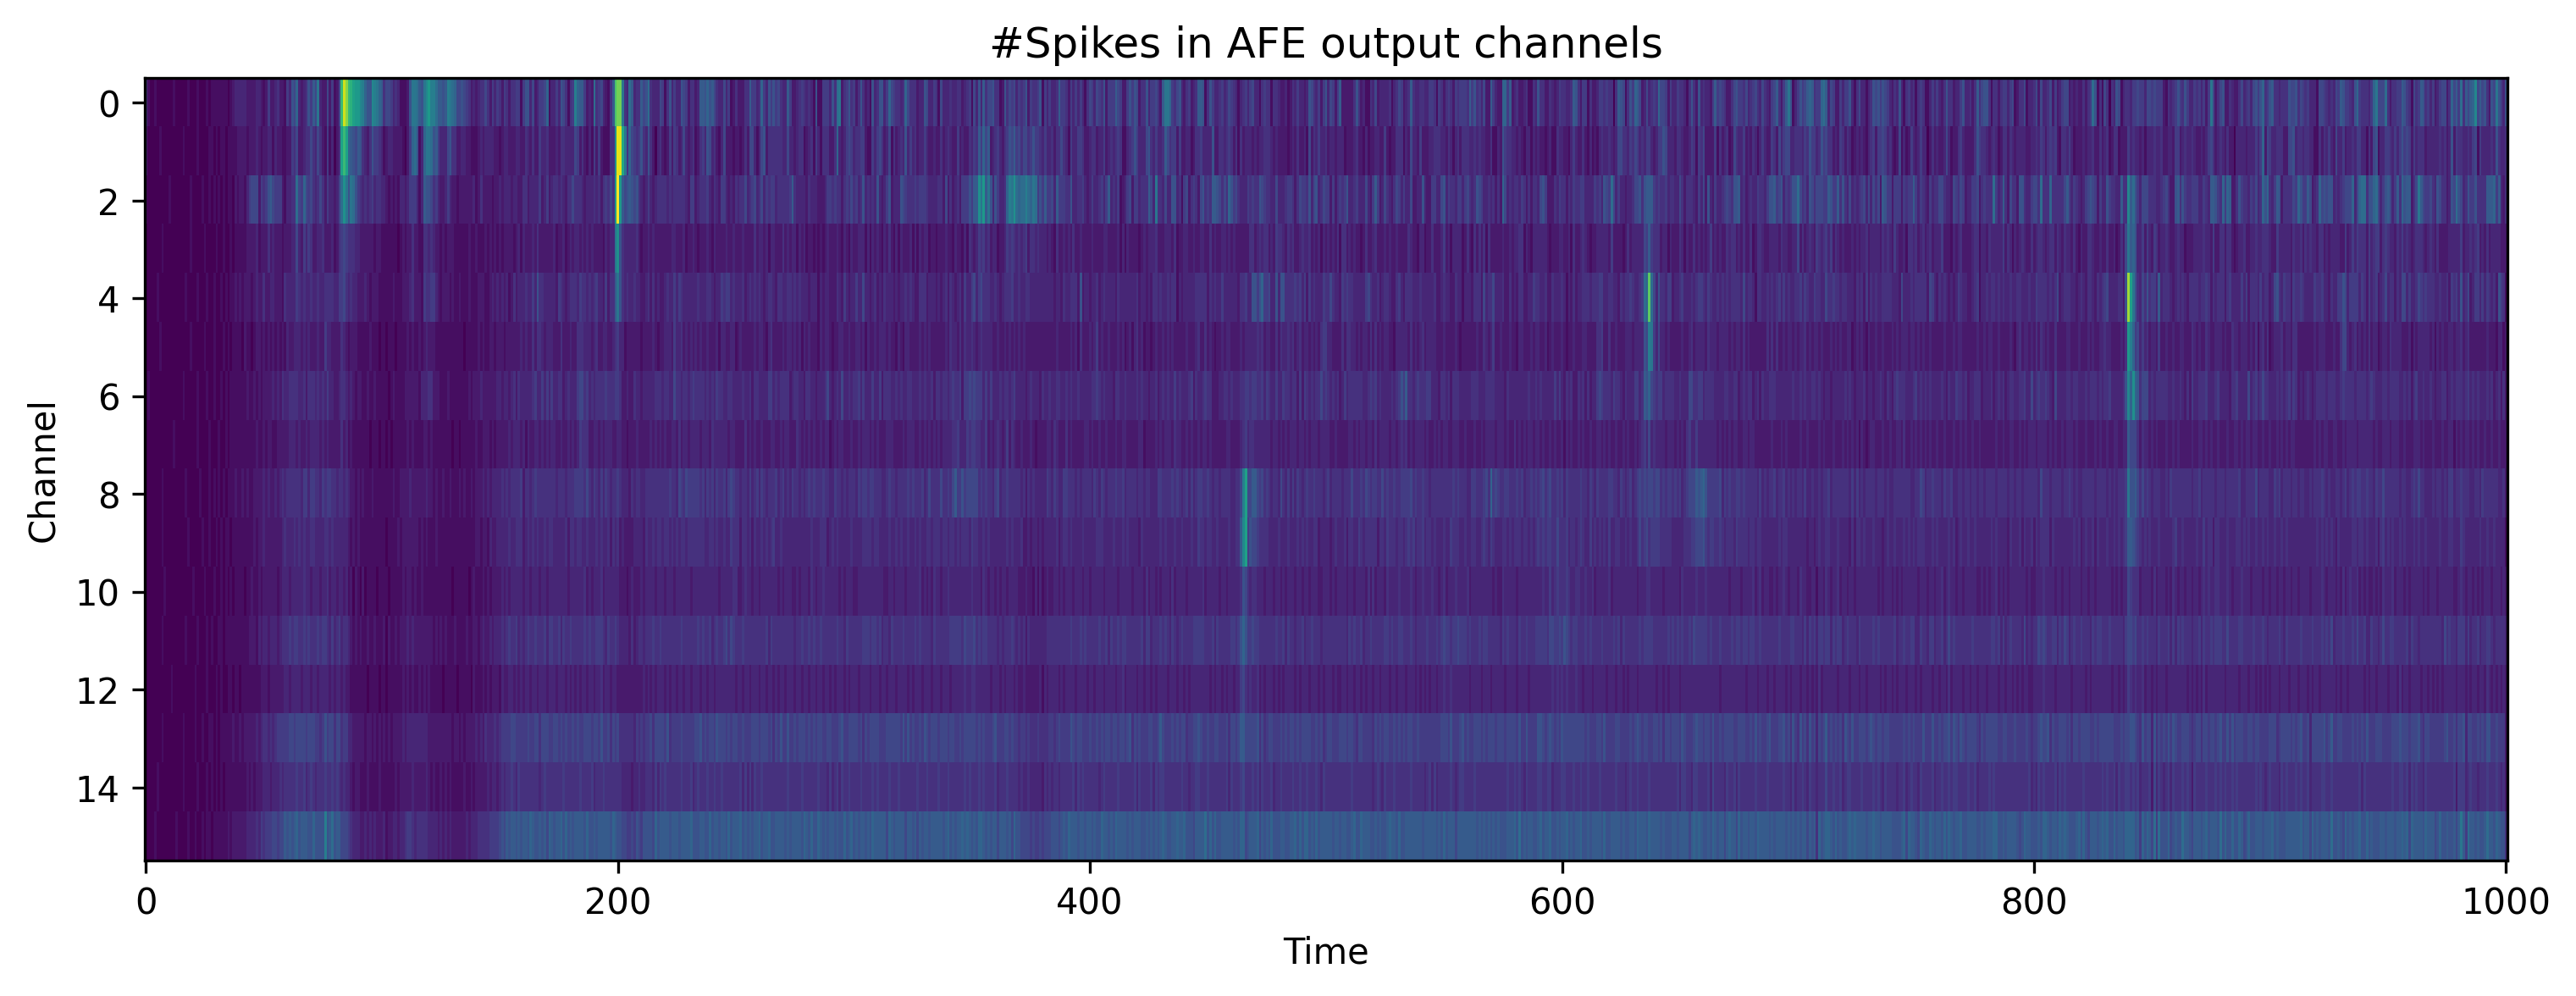

In [22]:
# - Plot some encoded audio events recorded from the AFE
plt.imshow(spikes_ts.T, aspect='auto', interpolation='none')
plt.title('#Spikes in AFE output channels')
plt.xlabel('Time')
plt.ylabel('Channel')
plt.show()


## Part III: Deploying the AFE and SNN cores in free-running inference mode

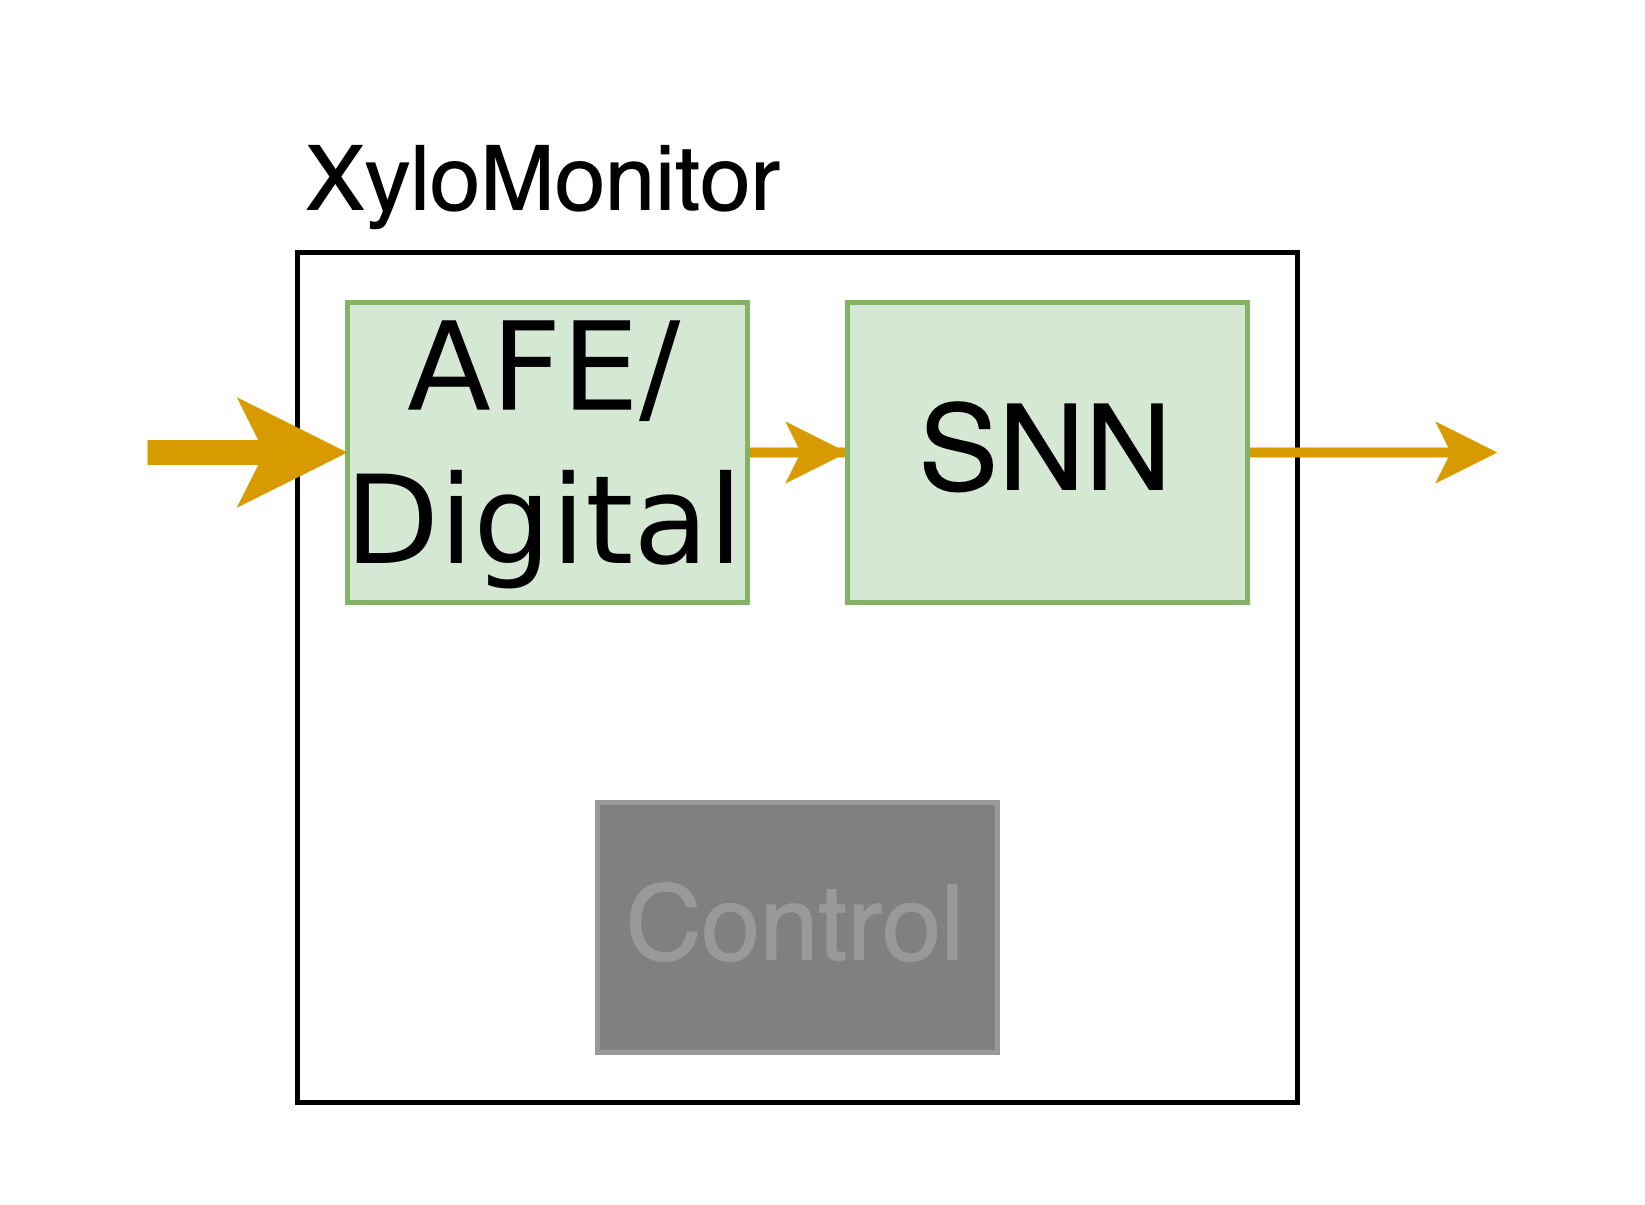

In [23]:
Image('XyloMonitor.png', width=400)

In [24]:
# - Find and connect to a XyloAudio HDK
xylo_hdk_nodes, modules, versions = find_xylo_hdks()
print(xylo_hdk_nodes)

hdk = None

for version, xylo in zip(versions, xylo_hdk_nodes):
    if version == "syns61201":
        hdk = xylo
    # - For XyloAudio 3
    if version == "syns65302":
        hdk = xylo

if hdk is None:
    assert False, 'This tutorial requires a connected XyloAudio HDK to demonstrate.'


The connected Xylo HDK contains a XyloAudio 3. Importing `rockpool.devices.xylo.syns65302`


[<samna.xyloAudio3.XyloAudio3TestBoard object at 0x793aac146f30>]

In [25]:
# - Use XyloMonitor to deploy to the HDK
output_mode = "Vmem"
amplify_level = "low"
hibernation = False
DN = True
T = 100

# - For XyloAudio 2
# - For XyloAudio 2 you need to wait 45s until the AFE auto-calibration is done
if xylo_board_name == 'XyloAudio2':
    modMonitor = xa2.XyloMonitor(hdk, config, dt=dt, output_mode=output_mode, amplify_level=amplify_level, hibernation_mode=hibernation, divisive_norm=DN)

# - For XyloAudio 3
# - XyloAudio 3 does not have the amplify_level parameter and does not do AFE auto-calibration
elif xylo_board_name == 'XyloAudio3':
    modMonitor = xa3.XyloMonitor(hdk, config, dt = dt, output_mode=output_mode, hibernation_mode=hibernation, dn_active=DN)

# - Perform inference on the Xylo board
# - The following line will evolve XyloMonitor for T time steps.
# - Keep in mind that this mode is using the microphone as input, hence the output might change according to the ambience noise 
output, _, _ = modMonitor(input_data=np.zeros((T, Nin)))
    

## Part IV: Measuring power on the XyloAudio HDK

In [26]:
# - Find and connect to a XyloAudio HDK
xylo_hdk_nodes, modules, versions = find_xylo_hdks()
print(xylo_hdk_nodes)

hdk = None

for version, xylo in zip(versions, xylo_hdk_nodes):
    if version == "syns61201":
        hdk = xylo
    # - For XyloAudio 3
    elif version == "syns65302":
        hdk = xylo

if hdk is None:
    assert False, 'This tutorial requires a connected XyloAudio HDK to demonstrate.'


The connected Xylo HDK contains a XyloAudio 3. Importing `rockpool.devices.xylo.syns65302`


[<samna.xyloAudio3.XyloAudio3TestBoard object at 0x793aac146f30>]

In [27]:
# - For XyloAudio 2
if xylo_board_name == 'XyloAudio2':
    # - Set a low clock frequency for the XyloAudio 2 device
    xa2utils.set_xylo_core_clock_freq(hdk, 6.25)
    # - Use XyloSamna to deploy to the HDK
    modSamna = xa2.XyloSamna(hdk, config, dt = 10e-3, power_frequency=20.)
# - For XyloAudio 3
elif xylo_board_name == 'XyloAudio3':
    import samna
    # - Set a low clock frequency for the XyloAudio 3 device
    xa3utils.set_xylo_core_clock_freq(hdk, 6.25)
    # - Use XyloSamna to deploy to the HDK
    modSamna = xa3.XyloSamna(hdk, config, dt = 10e-3, power_frequency=20.)
    
print(modSamna)

XyloSamna  with shape (2, 8, 2)

In [28]:
# - Generate some Poisson input
T = 1000
f = 0.4
input_spikes = np.random.rand(T, Nin) < f

# - Evolve some input on the SNN core, and record power during inference
out, _, record_dict = modSamna(input_spikes, record_power = True)

print(record_dict)

{
    'io_power': array([4.54719129e-05, 4.88430221e-05, 4.87487187e-05, 4.80746650e-05,
       4.85569697e-05, 4.80726627e-05, 4.82045371e-05, 4.73754746e-05,
       4.84810817e-05, 4.78287697e-05, 4.73328358e-05, 4.81322376e-05,
       4.80509204e-05, 4.80021423e-05, 4.84968992e-05, 4.76696014e-05,
       4.78420085e-05, 4.71209154e-05, 4.77895466e-05, 4.79866277e-05,
       4.76399162e-05, 4.78828543e-05, 4.81827949e-05, 4.89588489e-05,
       4.79126065e-05, 4.72762698e-05, 4.83834014e-05, 4.73687643e-05,
       4.75700992e-05, 4.76522411e-05, 4.81071113e-05, 4.84114194e-05,
       4.85988685e-05, 4.77163675e-05, 4.82974702e-05, 4.80813433e-05,
       4.74696104e-05, 4.80319481e-05, 4.86883525e-05, 4.78450742e-05,
       4.86692440e-05]),
    'analog_power': array([1.18443669e-05, 1.23179678e-05, 1.26875266e-05, 1.24300704e-05,
       1.22743352e-05, 1.29781737e-05, 1.23841250e-05, 1.22139998e-05,
       1.24850601e-05, 1.27515418e-05, 1.24521073e-05, 1.21028059e-05,
       1.29755745e-05, 1.25993214e-05, 1.16132323e-05, 1.18098862e-05,
       1.24686816e-05, 1.28677332e-05, 1.18616887e-05, 1.20067407e-05,
       1.18316261e-05, 1.22705814e-05, 1.31126381e-05, 1.19893002e-05,
       1.20273488e-05, 1.29092799e-05, 1.26378529e-05, 1.20903454e-05,
       1.23335602e-05, 1.23311322e-05, 1.22780009e-05, 1.21696093e-05,
       1.22683011e-05, 1.22580281e-05, 1.26974611e-05, 1.20620994e-05,
       1.23131590e-05, 1.23329524e-05, 1.22385276e-05, 1.20051580e-05,
       1.28488359e-05]),
    'digital_power': array([0.0005649 , 0.00056734, 0.00056615, 0.00056588, 0.00056465,
       0.00056725, 0.00056553, 0.00056678, 0.00056622, 0.00056481,
       0.00056638, 0.00056608, 0.00056671, 0.0005663 , 0.00056647,
       0.00056519, 0.00056672, 0.00056743, 0.00056482, 0.00056504,
       0.00056542, 0.00056618, 0.00056408, 0.00056582, 0.00056628,
       0.00056702, 0.00056535, 0.00056666, 0.00056632, 0.00056586,
       0.00056648, 0.00056668, 0.00056558, 0.00056564, 0.00056578,
       0.0005654 , 0.00056595, 0.00056565, 0.00056627, 0.00056569,
       0.00056762]),
    'inf_duration': 2.074521541595459
}

In [29]:
# - Measure idle power (no evolution)
from time import sleep
import samna

modSamna._power_buf.get_events()
sleep(5.)
power = modSamna._power_buf.get_events()

# - For XyloAudio 2
if xylo_board_name == 'XyloAudio2':
    power_idle = ([], [], [], [])
    for p in power:
        power_idle[p.channel].append(p.value)

    idle_power_per_channel = np.mean(np.stack(power_idle), axis = 1)
    
    channels = samna.xyloA2TestBoard.MeasurementChannels
    io_power = idle_power_per_channel[channels.Io]
    afe_core_power = idle_power_per_channel[channels.LogicAfe]
    afe_ldo_power = idle_power_per_channel[channels.IoAfe]
    snn_core_power = idle_power_per_channel[channels.Logic]
    
    print(f'XyloAudio 2\nAll IO:\t\t{io_power * 1e6:.1f} µW\nAFE core:\t{afe_core_power * 1e6:.1f} µW\nInternal LDO:\t{afe_ldo_power * 1e6:.1f} µW\nSNN core logic:\t{snn_core_power*1e6:.1f} µW')

# - For XyloAudio 3
elif xylo_board_name == 'XyloAudio3':
    power_idle = ([], [], [])
    for p in power:
        power_idle[p.channel].append(p.value)

    channels = samna.xyloAudio3.MeasurementChannels
    idle_power_per_channel = np.mean(np.stack(power_idle), axis = 1)
    io_power = idle_power_per_channel[channels.Io] 
    analog_power = idle_power_per_channel[channels.AnalogLogic] 
    digital_power = idle_power_per_channel[channels.DigitalLogic]
    print(f'XyloAudio 3\nAll IO:\t\t{io_power * 1e6:.1f} µW\nAFE core:\t{analog_power * 1e6:.1f} µW\nSNN core logic:\t{digital_power*1e6:.1f} µW')



XyloAudio 3
All IO:         35.9 µW
AFE core:       12.3 µW
SNN core logic: 558.6 µW

### Hints on reducing power consumption

In [30]:
if xylo_board_name == 'XyloAudio2':
    help(xa2utils.set_xylo_core_clock_freq)
elif xylo_board_name == 'XyloAudio3':
    help(xa3utils.set_xylo_core_clock_freq)   


Help on function set_xylo_core_clock_freq in module rockpool.devices.xylo.syns65302.xa3_devkit_utils:

set_xylo_core_clock_freq(device: samna.xyloAudio3.XyloAudio3TestBoard, main_clock_frequency_MHz: float) -> None
    Set the internal core clock frequency used by Xylo
    
    Args:
        device (XyloAudio3HDK): A XyloAudio 3 device to configure
        main_clock_frequency_MHz (float): The main clock frequency of XyloAudio 3 in MHz



### Estimate the required master clock frequency for real-time operation

In [31]:
if xylo_board_name == 'XyloAudio2':
    from rockpool.devices.xylo.syns61201 import cycles_model, est_clock_freq
elif xylo_board_name == 'XyloAudio3':
    from rockpool.devices.xylo.syns65302 import cycles_model, est_clock_freq
help(cycles_model)

Help on function cycles_model in module rockpool.devices.xylo.syns63300.power_cycles_model:

cycles_model(config: Union[samna.xyloImu.configuration.XyloConfiguration, samna.xyloAudio3.configuration.XyloConfiguration], input_sp: Union[float, numpy.ndarray, torch.Tensor, array] = 1.0, hidden_sp: Union[float, numpy.ndarray, torch.Tensor, array] = 1.0, output_sp: Union[float, numpy.ndarray, torch.Tensor, array] = 1.0) -> float
    Calculate the average number of cycles required for a given network architecture
    
    This function contains a model which estimates the number of master clock cycles required for the Xylo SNN SYNS61202 and SYNS65302 inference cores to compute one time-step for a given chip configuration in ``config``. Use :py:func:`~.devices.xylo.syns61201.config_from_specification` to obtain a chip configuration, along with :py:meth:`.Module.as_graph` and :py:func:`~.devices.xylo.syns61201.mapper`, as described in the deployment tutorials for Xylo.
    
    By default the m

In [32]:
help(est_clock_freq)

Help on function est_clock_freq in module rockpool.devices.xylo.syns63300.power_cycles_model:

est_clock_freq(config: Union[samna.xyloImu.configuration.XyloConfiguration, samna.xyloAudio3.configuration.XyloConfiguration], dt: float, margin: float = 0.2)
    Estimate the required master clock frequency, to run a network in real-time
    
    This function will perform a worst-case analysis, assuming that every input channel, every hidden neuron and every output neuron fire an event on each `dt`. An additional margin is included (Default: 20%), to guarantee that the model will run in real time at the suggested master clock frequency.
    
    Args:
        config (Union[XyloIMUConfig, XyloA3Config]):  A Xylo configuration for which to estimate the required clock frequency
        dt (float): The required network `dt`, in seconds
        margin (float): The additional overhead safety margin to add to the estimation, as a fraction. Default: `0.2` (20%)



In [33]:
print(f"This network requires {cycles_model(config)} master clock cycles per network time-step.")
print(f"This network requires a master clock of {est_clock_freq(config, dt) / 1e6:.2f} MHz for real-time operation.")

This network requires 562.0 master clock cycles per network time-step.

This network requires a master clock of 0.07 MHz for real-time operation.